<a href="https://colab.research.google.com/github/sunny0103/DeepLearning_nlp_projects/blob/main/korea_news_topics/korea_news_topics_classification_polyglot_p_tunning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
cd "/content/drive/MyDrive/Data/KorNews_topic"

/content/drive/MyDrive/Data/KorNews_topic


In [3]:
!pip install evaluate tqdm datasets scikit-learn scipy peft

In [4]:
from transformers import (AutoModelForSequenceClassification,
                          AutoTokenizer,
                          DataCollatorWithPadding,
                          TrainingArguments,
                          Trainer,
                          get_linear_schedule_with_warmup)

from datasets import load_dataset, Dataset
from sklearn.model_selection import train_test_split
from peft import (get_peft_config,
                  get_peft_model,
                  get_peft_model_state_dict,
                  set_peft_model_state_dict,
                  PeftType,
                  PromptEncoderConfig)

from torch.optim import AdamW

import evaluate
import torch
import numpy as np
import pandas as pd
import random
import os
from torch.utils.data import DataLoader
from tqdm import tqdm

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


seed_everything(42)
SEED = 42

In [6]:
data = pd.read_csv('./train_data.csv')
topic = pd.read_csv('./topic_dict.csv')
display(topic)
display(data.head())

,topic,topic_idx
0,IT과학,0
1,경제,1
2,사회,2
3,생활문화,3
4,세계,4
5,스포츠,5
6,정치,6


,index,title,topic_idx
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4


In [7]:
id2label = topic.to_dict()['topic']
label2id = {label: id for id, label in id2label.items()}
print(id2label)
print(label2id)


{0: 'IT과학', 1: '경제', 2: '사회', 3: '생활문화', 4: '세계', 5: '스포츠', 6: '정치'}
{'IT과학': 0, '경제': 1, '사회': 2, '생활문화': 3, '세계': 4, '스포츠': 5, '정치': 6}


In [8]:
data.isnull().sum()

index        0
title        0
topic_idx    0
dtype: int64

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(data.index.values,
                                                    data.topic_idx.values,
                                                    test_size=0.2,
                                                    stratify=data.topic_idx.values,
                                                    random_state = SEED)

In [10]:
data['data_type'] =['not_set'] * data.shape[0]

data.loc[X_train, 'data_type'] = 'train'
data.loc[X_valid, 'data_type'] = 'valid'
data.head()

,index,title,topic_idx,data_type
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4,train
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4,train
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4,train
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4,train
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4,valid


In [11]:
pd.DataFrame(data.groupby(['topic_idx', 'data_type'])['index'].count())

index
topic_idx data_type       
0         train       3859
          valid        965
1         train       4978
          valid       1244
2         train       5890
          valid       1472
3         train       4746
          valid       1187
4         train       6103
          valid       1526
5         train       5546
          valid       1387
6         train       5401
          valid       1350

In [12]:
# split train valid dataset
train_set = data[data.data_type == 'train']
valid_set = data[data.data_type == 'valid']

In [13]:
train_set = train_set.reset_index(drop=True)
valid_set = valid_set.reset_index(drop=True)

### P-tuning
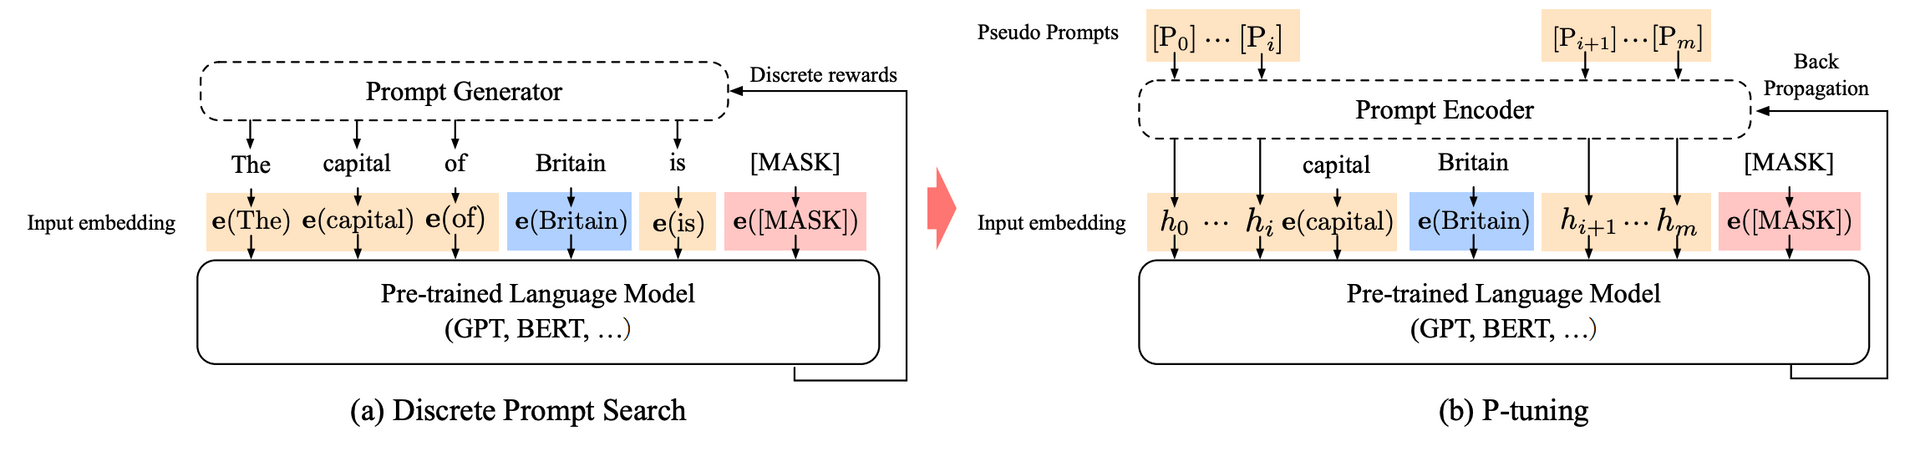

In [14]:
model_name_or_path = 'EleutherAI/polyglot-ko-1.3b'
device = 'cuda'
batch_size = 1
peft_config = PromptEncoderConfig(task_type="SEQ_CLS",  num_virtual_tokens=20, encoder_hidden_size=128)

In [15]:
padding_side = 'left'

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, padding_side=padding_side)
if getattr(tokenizer, 'pad_token_id') is None:
  tokenizer.pad_token_id = tokenizer.eos_token_id

In [16]:
train_dataset = Dataset.from_pandas(train_set)
valid_dataset = Dataset.from_pandas(valid_set)
train_dataset

Dataset({
    features: ['index', 'title', 'topic_idx', 'data_type'],
    num_rows: 36523
})

In [17]:
def tokenize_function(examples):
  outputs = tokenizer(examples['title'], truncation=True, max_length=None)
  return outputs

In [18]:
tokenized_train = train_dataset.map(tokenize_function,
                                    batched=True,
                                    remove_columns =['index', 'title', 'data_type'])

tokenized_valid = valid_dataset.map(tokenize_function,
                                    batched=True,
                                    remove_columns =['index', 'title','data_type'])

tokenized_train = tokenized_train.rename_column("topic_idx", "labels")
tokenized_valid = tokenized_valid.rename_column("topic_idx", "labels")

Map:   0%|          | 0/36523 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/9131 [00:00<?, ? examples/s]

In [19]:
tokenized_train

Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 36523
})

In [20]:
def collate_fn(examples):
    return tokenizer.pad(examples, padding="longest", return_tensors="pt")

In [21]:
train_dataloader = DataLoader(tokenized_train,
                              batch_size=batch_size,
                              shuffle=True,
                              collate_fn=collate_fn)
eval_dataloader = DataLoader(tokenized_valid,
                             batch_size=batch_size,
                             collate_fn=collate_fn)

In [22]:
model = AutoModelForSequenceClassification.from_pretrained(model_name_or_path,
                                                           return_dict=True,
                                                           num_labels=len(id2label),
                                                           id2label=id2label,
                                                           label2id=label2id,)
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()
model

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Some weights of GPTNeoXForSequenceClassification were not initialized from the model checkpoint at EleutherAI/polyglot-ko-1.3b and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 598,272 || all params: 1,270,819,072 || trainable%: 0.04707766929075487


PeftModelForSequenceClassification(
  (base_model): GPTNeoXForSequenceClassification(
    (gpt_neox): GPTNeoXModel(
      (embed_in): Embedding(30080, 2048)
      (emb_dropout): Dropout(p=0.0, inplace=False)
      (layers): ModuleList(
        (0-23): 24 x GPTNeoXLayer(
          (input_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
          (post_attention_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
          (post_attention_dropout): Dropout(p=0.0, inplace=False)
          (post_mlp_dropout): Dropout(p=0.0, inplace=False)
          (attention): GPTNeoXAttention(
            (rotary_emb): GPTNeoXRotaryEmbedding()
            (query_key_value): Linear(in_features=2048, out_features=6144, bias=True)
            (dense): Linear(in_features=2048, out_features=2048, bias=True)
            (attention_dropout): Dropout(p=0.0, inplace=False)
          )
          (mlp): GPTNeoXMLP(
            (dense_h_to_4h): Linear(in_features=2048, out_features=8

In [23]:
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
  predictions, labels = eval_pred
  predictions = np.argmax(predictions, axis=1)
  return metric.compute(predictions=predictions, references=labels)

In [24]:
def get_grouped_params(model, no_decay=["bias", "LayerNorm.weight"], weight_decay=0.1):
    params_with_wd, params_without_wd = [], []
    for n, p in model.named_parameters():
        if any(nd in n for nd in no_decay):
            params_without_wd.append(p)
        else:
            params_with_wd.append(p)
    return [
        {"params": params_with_wd, "weight_decay": weight_decay},
        {"params": params_without_wd, "weight_decay": 0.0},
    ]


In [25]:
num_epochs = 5
lr = 1e-3
optimizer = AdamW(get_grouped_params(model), lr=lr)

# Instantiate scheduler
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=0,  # 0.06*(len(train_dataloader) * num_epochs),
    num_training_steps=(len(train_dataloader) * num_epochs),
)

In [26]:
model.to(device)

best_model_path = "./polyglot_best_tuning.pt"
best_acc = 0.
for epoch in range(num_epochs):
    model.train()
    for step, batch in enumerate(tqdm(train_dataloader)):
        batch.to(device)
        outputs = model(batch['input_ids'], labels=batch['labels'])
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

    model.eval()
    for step, batch in enumerate(tqdm(eval_dataloader)):
        batch.to(device)
        with torch.no_grad():
            outputs = model(batch['input_ids'], labels=batch['labels'])
        predictions = outputs.logits.argmax(dim=-1)
        predictions, references = predictions, batch["labels"]
        metric.add_batch(
            predictions=predictions,
            references=references,
        )

    eval_metric = metric.compute()
    print(f"epoch {epoch}:", eval_metric)
    if eval_metric['accuracy'] >= best_acc:
        best_acc = eval_metric['accuracy']
        model.save_pretrained(best_model_path)
        tokenizer.save_pretrained(best_model_path)
    else:
      break

100%|██████████| 9131/9131 [04:01<00:00, 37.76it/s]


epoch 0: {'accuracy': 0.8638703318366006}


100%|██████████| 9131/9131 [04:03<00:00, 37.57it/s]


epoch 1: {'accuracy': 0.853904282115869}


In [27]:
test_set = pd.read_csv('./test_data.csv')
test_set.head()

,index,title
0,45654,유튜브 내달 2일까지 크리에이터 지원 공간 운영
1,45655,어버이날 맑다가 흐려져…남부지방 옅은 황사
2,45656,내년부터 국가RD 평가 때 논문건수는 반영 않는다
3,45657,김명자 신임 과총 회장 원로와 젊은 과학자 지혜 모을 것
4,45658,회색인간 작가 김동식 양심고백 등 새 소설집 2권 출간


In [28]:
test_dataset = Dataset.from_pandas(test_set)

In [30]:
tokenized_test = test_dataset.map(tokenize_function,
                                    batched=True,
                                    remove_columns =['index', 'title'])

Map:   0%|          | 0/9131 [00:00<?, ? examples/s]

In [32]:
tokenized_test

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 9131
})

In [31]:
test_dataloader = DataLoader(tokenized_test,
                             batch_size=batch_size,
                             collate_fn=collate_fn,
                             shuffle=False)

In [48]:
import torch
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM, AutoTokenizer

config = PeftConfig.from_pretrained(best_model_path)
inference_model = AutoModelForSequenceClassification.from_pretrained(config.base_model_name_or_path,
                                                                     num_labels=len(id2label),
                                                                     id2label=id2label,
                                                                     label2id=label2id)
tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)

# Load the prompt tuning model
inference_model = PeftModel.from_pretrained(inference_model, best_model_path)

inference_model.to(device)
inference_model.eval()
preds =  None
for step, batch in enumerate(tqdm(test_dataloader)):
    batch.to(device)
    with torch.no_grad():
        outputs = inference_model(batch['input_ids'])
    predictions = outputs.logits.argmax(dim=-1)
    if step == 0:
      preds = predictions
    else:
      preds = torch.cat((preds, predictions), dim=0)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Some weights of GPTNeoXForSequenceClassification were not initialized from the model checkpoint at EleutherAI/polyglot-ko-1.3b and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 9131/9131 [03:56<00:00, 38.66it/s]


In [53]:
print(preds)
len(preds)

[2 3 2 ... 2 2 6]


9131

In [54]:
submission = pd.read_csv('./sample_submission.csv')
submission.head()

,index,topic_idx
0,45654,0
1,45655,0
2,45656,0
3,45657,0
4,45658,0


In [56]:
preds=preds.cpu().numpy()

In [57]:
submission['topic_idx'] = preds
submission.head()

,index,topic_idx
0,45654,2
1,45655,3
2,45656,2
3,45657,2
4,45658,3


In [58]:
submission.to_csv('./polyglot_p_tuning_submit.csv', index=False)